In [85]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import bambi as bmb

%load_ext autoreload
%autoreload 2

# Ordinal Regression

In some scenarios, the response variable is discrete, like a count, and ordered. For example, a rating from 1 to 5. The result is a set of **ordered categories**. Ordered category data presents three challenges when modelling:

1. Unlike a count, the differences in the values are not necessarily equidistant. For example, it may be much harder for a restuarant to go from 4 to 5 stars than from 2 to 3 stars. 
2. The distribution of ordinal responses may be nonnormal, particularly if very low or high values are infrequently chosen.
3. The variances of the unobserved variables that underlie the observed ordered category may differ between the category, time points, etc. 

Thus, treating ordered categories as continuous is not appropriate. To this extent, Bambi supports two classes of ordinal regression models: (1) cumulative link, and (2) sequential link. Below, it is demonstrated how to fit these two models using Bambi to overcome the challenges of ordered category response data.

## Cumulative link model

In principle, an ordered categorical response is a multinomial prediction problem. However, the constraint that the categories are *ordered* requires a different approach. Ideally, what we would like is for any predictor variable, as it increases, predictions are moved progressively (increased) through the categories in sequence. 

To achieve this, a cumulative link function is used. A cumulative model assumes that the observed ordinal category $Y$ is generated from an underlying latent continuous variable $\hat{Y}$, which is then mapped to the observed category $Y$ via a set of cutpoints $\tau$. For example, the model assumes $K$ cutpoints $\tau_{k}$ that partition $\hat{Y}$ into $K+1$ observable, ordered categories.

By linking a linear model to a cumulative probability, it is possible to guarantee the ordering of outcomes. The cumulative probability of an ordered category is the probability of that value or *any smaller value*. Building off of the rating example above, the probability of a 4 is the probability of 4, 3, 2, and 1.

The log-cumulative-odds that a response value $y_i$ is equal to or less than some possible outcome value $k$ is given by:

$$\text{log} \frac{Pr(y_i \le k)}{1 - Pr(y_i \le k)} = \alpha_k$$

where $\alpha_k$ is the intercept of outcome $k$. Each intercept $\alpha_k$ implies a cumulative probability for each $k$. Since the largest response value always has a cumulative probability of 1, we effectively do not need a parameter for it due to the law of total probability. For example, for $K = 5$ possible response values, we only need $K − 1 = 4$ intercepts.

### The moral intuition dataset

To illustrate an ordinal model with a cumulative link function, we will model data from a series of experiments conducted by philsophers (this example comes from Richard McElreath's [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)). The experiments aim to collect empirical evidence relevant to debates about moral intuition, the forms of reasoning through which people develop judgments about the moral goodness and badness of actions. 

In the dataset there are 12 columns and 9930 rows, comprising data for 331 unique individuals. The response we are interested in `response`, is an integer from 1 to 7 indicating how morally permissible the participant found the action to be taken (or not) in the story. The predictors are as follows:

- `action`: a factor with levels 0 and 1 where 1 indicates that the story contained "harm caused by action is morally worse than equivalent harm caused by omission".
- `intention`: a factor with levels 0 and 1 where 1 indicates that the story contained "harm intended as the means to a goal is morally worse than equivalent harm foreseen as the side effect of a goal".
- `contact`: a factor with levels 0 and 1 where 1 indicates that the story contained "using physical contact to cause harm to a victim is morally worse than causing equivalent harm to a victim without using physical contact".

In [3]:
trolly = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Trolley.csv", sep=";")
trolly = trolly[["response", "action", "intention", "contact"]]
trolly["action"] = pd.Categorical(trolly["action"], ordered=False)
trolly["intention"] = pd.Categorical(trolly["intention"], ordered=False)
trolly["contact"] = pd.Categorical(trolly["contact"], ordered=False)
trolly["response"] = pd.Categorical(trolly["response"], ordered=True)

In [4]:
# 7 ordered categories from 1-7
trolly.response.unique()

[4, 3, 5, 2, 1, 7, 6]
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

### Intercept only model

Before we fit a model with predictors, let's attempt to recover the parameters of an ordered distribution with an intercepts only model to get a feel for the cumulative link function. First, to compare the intercepts only model, we compute the empirical log-cumulative-odds of the categories directly from the data below. 

In [102]:
pr_k = trolly.response.value_counts().sort_index().values / trolly.shape[0]
cum_pr_k = np.cumsum(pr_k)
logit_func = lambda x: np.log(x / (1 - x))
cum_logit = logit_func(cum_pr_k)
cum_logit

/var/folders/rl/y69t95y51g90tvd6gjzzs59h0000gn/T/ipykernel_32825/1548491577.py:3: RuntimeWarning: invalid value encountered in log
  logit_func = lambda x: np.log(x / (1 - x))


array([-1.91609116, -1.26660559, -0.718634  ,  0.24778573,  0.88986365,
        1.76938091,         nan])

In [95]:
model = bmb.Model("response ~ 1", data=trolly, family="cumulative")
idata = model.fit()

/Users/gabestechschulte/Documents/repos/bambi/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [response_threshold]


/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in add
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in add
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in add
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in add
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seco

In [6]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
response_threshold[0],-1.923,0.030,-1.981,-1.869,0.0,0.0,4206.0,3065.0,1.0
response_threshold[1],-1.270,0.024,-1.314,-1.225,0.0,0.0,5095.0,3329.0,1.0
response_threshold[2],-0.719,0.021,-0.760,-0.681,0.0,0.0,5042.0,3302.0,1.0
response_threshold[3],0.248,0.020,0.212,0.286,0.0,0.0,4812.0,3272.0,1.0
response_threshold[4],0.892,0.022,0.851,0.933,0.0,0.0,4978.0,3397.0,1.0
response_threshold[5],1.775,0.028,1.721,1.827,0.0,0.0,5575.0,3372.0,1.0


Viewing the summary dataframe, we see a total of six cutpoints (`response_threshold`) coefficients. Why six? Remember, we get the last parameter for free, so we only need $K-1$ cutpoints. The index (using zero based indexing) of the `response_threshold` indicates the category that the cutpoint is associated with. Comparing to the empirical log-cumulative-odds computation above, the mean of the posterior distribution for each category is close to the empirical value.

As the the log cumalative link is used, we need to apply the inverse of the logit function to transform back to cumulative probabilities. Below, we plot the cumulative probabilities for each category. 

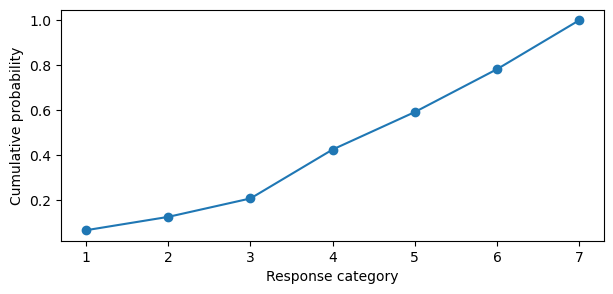

In [103]:
expit_func = lambda x: 1 / (1 + np.exp(-x))
cumprobs = expit_func(idata.posterior.response_threshold).mean(("chain", "draw"))
cumprobs = np.append(cumprobs, 1)

plt.figure(figsize=(7, 3))
plt.plot(sorted(trolly.response.unique()), cumprobs, marker='o')
plt.ylabel("Cumulative probability")
plt.xlabel("Response category");

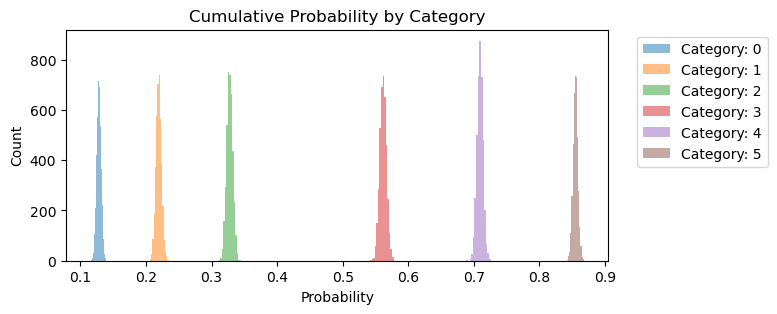

In [96]:
fig, ax = plt.subplots(figsize=(7, 3))
for i in range(6):
    outcome = expit_func(idata.posterior.response_threshold).sel(response_threshold_dim=i).to_numpy().flatten()
    ax.hist(outcome, bins=15, alpha=0.5, label=f"Category: {i}")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.set_title("Cumulative Probability by Category")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

Notice in both plots above, the jump in cumulative probability from category 3 to 4. Additionally, the estimates of the coefficients is precise for each category. Now that we have an understanding how the cumulative link function is applied to produce ordered cumulative outcomes, we will add predictors to the model. 

### Adding predictors


To include predictor variables, we define the log-cumulative-odds of each response $k$ as a sum of its intercept $\alpha_k$ and a linear model $\phi$ where $\phi_i = \beta x_i$

$$\text{log} \frac{Pr(y_i \le k)}{1 - Pr(y_i \le k)} = \alpha_k - \phi_i$$

The linear model $\phi$ is subtracted from each intercept because if we decrease the log-cumulative-odds of every outcome value $k$ below the maximum, this shifts probability mass upwards towards higher outcome values. Thus, positive $\beta$ values correspond to increasing $x$, which is associated with an increase in the mean $y$.

However, to add predictors for ordinal models in Bambi, we continue to use the familiar syntax.

In [97]:
model = bmb.Model(
    "response ~ action + intention + contact + action:intention + contact:intention", 
    data=trolly, 
    family="cumulative"
)
idata = model.fit()

/Users/gabestechschulte/Documents/repos/bambi/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [response_threshold, action, intention, contact, action:intention, contact:intention]


/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


In the summary dataframe below, we only select the predictor variables as the cutpoints are not of interest at the moment.

In [54]:
az.summary(
    idata, 
    var_names=["action", "intention", "contact", 
               "action:intention", "contact:intention"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
action[1],-0.466,0.055,-0.567,-0.361,0.001,0.001,2387.0,2733.0,1.0
intention[1],-0.276,0.058,-0.392,-0.174,0.001,0.001,2376.0,2645.0,1.0
contact[1],-0.325,0.071,-0.459,-0.195,0.001,0.001,2709.0,2889.0,1.0
"action:intention[1, 1]",-0.455,0.080,-0.600,-0.299,0.002,0.001,2483.0,2882.0,1.0
"contact:intention[1, 1]",-1.284,0.102,-1.461,-1.078,0.002,0.001,2759.0,2926.0,1.0


The posterior distribution of the slopes are all negative indicating that each of these story features reduces the rating—the acceptability of the story. Below, a forest plot is used to make this insight more clear.

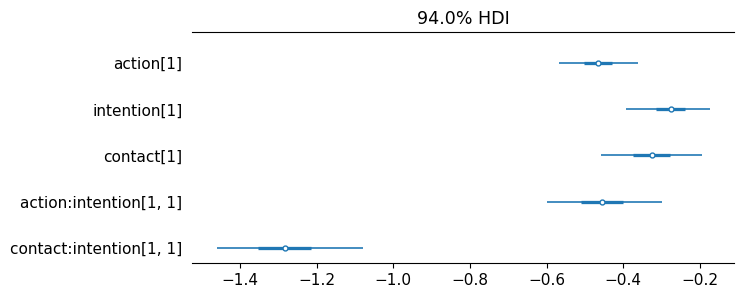

In [55]:
az.plot_forest(
    idata,
    combined=True,
    var_names=["action", "intention", "contact", 
               "action:intention", "contact:intention"],
    figsize=(7, 3),
    textsize=11
);

Again, we can plot the cumulative probability of each category. Compared to the same plot above, notice how most of the category probabilities have been shifted to the left. Additionally, there is more uncertainty for category 3, 4, and 5.

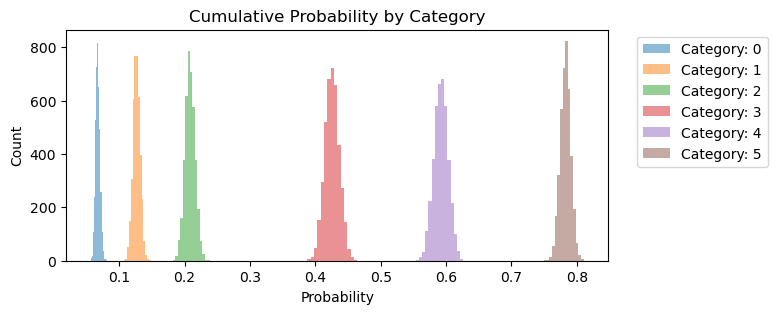

In [98]:
fig, ax = plt.subplots(figsize=(7, 3))
for i in range(6):
    outcome = expit_func(idata.posterior.response_threshold).sel(response_threshold_dim=i).to_numpy().flatten()
    ax.hist(outcome, bins=15, alpha=0.5, label=f"Category: {i}")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.set_title("Cumulative Probability by Category")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

#### Posterior predictive distribution

To get a sense of how well the ordinal model fits the data, we can plot samples from the posterior predictive distribution. 

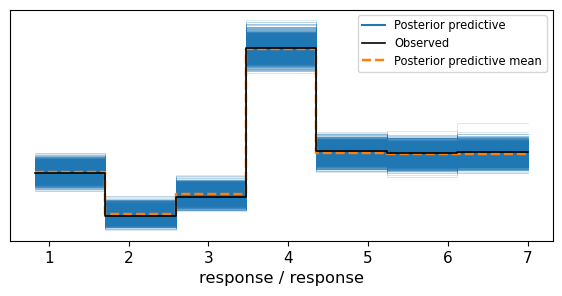

In [105]:
idata_pps = model.predict(idata=idata, kind="pps", inplace=False)

ax = az.plot_ppc(idata_pps, figsize=(7, 3), textsize=11)
ax.set_xticks(np.linspace(0.2, 7, 7))
ax.set_xticklabels(model.response_component.response_term.levels);

Looking at the observed and posterior predictive mean, the model captures the observed frequencies of the categories well. 

In [ ]:
# does not work because predictions are a vector of probabilities
bmb.interpret.predictions(
    model=model,
    idata=idata,
    covariates="action"
)

### Changing the default prior of cutpoints


**TO DO**